### 

In [1]:
import os
import joblib
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ser-processed/features/spectrogram_padded.pkl
/kaggle/input/ser-processed/features/spectrogram_features.pkl
/kaggle/input/ser-processed/features/aggregated_features.pkl
/kaggle/input/ser-processed/features/mfcc_padded.pkl
/kaggle/input/ser-processed/features/functional_features.pkl
/kaggle/input/ser-processed/features/mfcc_features.pkl


In [3]:

spectrogram_features = joblib.load('/kaggle/input/ser-processed/features/spectrogram_features.pkl')
mfcc_features = joblib.load('/kaggle/input/ser-processed/features/mfcc_features.pkl')
functional_features = joblib.load('/kaggle/input/ser-processed/features/functional_features.pkl')
aggregated_features = joblib.load('/kaggle/input/ser-processed/features/aggregated_features.pkl')

# Feature based model

In [4]:
X = functional_features
le = LabelEncoder()
Y = le.fit_transform(X['Emotion'])

X = X.drop(['Emotion','filepath'], axis=1)
X = StandardScaler().fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42) 

In [6]:
xgb_model = xgb.XGBClassifier(random_state=42, n_estimators=200, max_depth=6, learning_rate=0.5)

xgb_model.fit(X_train, y_train)


pred_xgb_test = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred_xgb_test))

pred_xgb_test = xgb_model.predict_proba(X_test)
pred_xgb_train = xgb_model.predict_proba(X_train)

Accuracy: 0.78955042527339


# Spectrogram based model

In [7]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Activation, Input, TimeDistributed, MaxPooling2D, Conv2D, AveragePooling2D, LSTM, BatchNormalization, Reshape, MaxPool1D, MaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2024-05-22 20:11:43.211341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 20:11:43.211439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 20:11:43.333534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
def preprocess_data(X, Y, random_state=42):
    df = pd.DataFrame([x.shape for x in X])
    dim2max = df[1].max()
    X = [np.pad(x, ((0, 0), (0, dim2max - x.shape[1])), mode='constant', constant_values=0) for x in X]
    X = [x[:, :128] for x in X]
    Y_names = np.unique(Y)
    Y = LabelEncoder().fit(Y).transform(Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=random_state)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    Y_train = to_categorical(Y_train, num_classes=np.unique(Y).size)
    Y_test = to_categorical(Y_test, num_classes=np.unique(Y).size)

    print(X_train[10].shape, X_test[10].shape)
    return X_train, X_test, Y_train, Y_test, Y_names


Y = functional_features['Emotion']
X = spectrogram_features
X_train, X_test, Y_train, Y_test, Y_names = preprocess_data(X, Y)

(128, 128) (128, 128)


In [9]:
## Check if we correctly mapped spectrograms to sound features
np.sum(np.where(Y_test)[1]-y_test)==0

True

In [10]:
def Normalized_CNN() :
    model = Sequential()
    model.add(Conv1D(64, 5, padding='same', input_shape=(128, 128)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(7))
    model.add(Activation('softmax'))
    print(model.summary())
    return model

In [11]:
Normalized_CNN_1 = Normalized_CNN()
Normalized_CNN_1.compile(optimizer=SGD(learning_rate=0.003, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])
Normalized_CNN_history_1 = Normalized_CNN_1.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        57,351 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,631 (385.28 KB)

 Trainable params: 98,503 (384.78 KB)

 Non-trainable params: 128 (512.00 B)

None
Epoch 1/100
 48/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2200 - loss: 2.0792

I0000 00:00:1716408725.499706     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716408725.517105     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2846 - loss: 2.0145

W0000 00:00:1716408729.211537     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


301/301 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.2846 - loss: 2.0143 - val_accuracy: 0.3439 - val_loss: 1.8004
Epoch 2/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3632 - loss: 1.7291 - val_accuracy: 0.3927 - val_loss: 1.6882
Epoch 3/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3985 - loss: 1.5808 - val_accuracy: 0.4046 - val_loss: 1.6433
Epoch 4/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4355 - loss: 1.5190 - val_accuracy: 0.4103 - val_loss: 1.6132
Epoch 5/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4480 - loss: 1.4678 - val_accuracy: 0.4367 - val_loss: 1.5839
Epoch 6/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4719 - loss: 1.4180 - val_accuracy: 0.4532 - val_loss: 1.5554
Epoch 7/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4822 - loss: 1.3950 - val_accuracy: 0.4389 - val_loss: 1.5481
Epoch 8/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4868 - loss: 1.3681 - val_accuracy: 0.42

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Loss: 1.4889938831329346
Test Accuracy: 0.5442284345626831


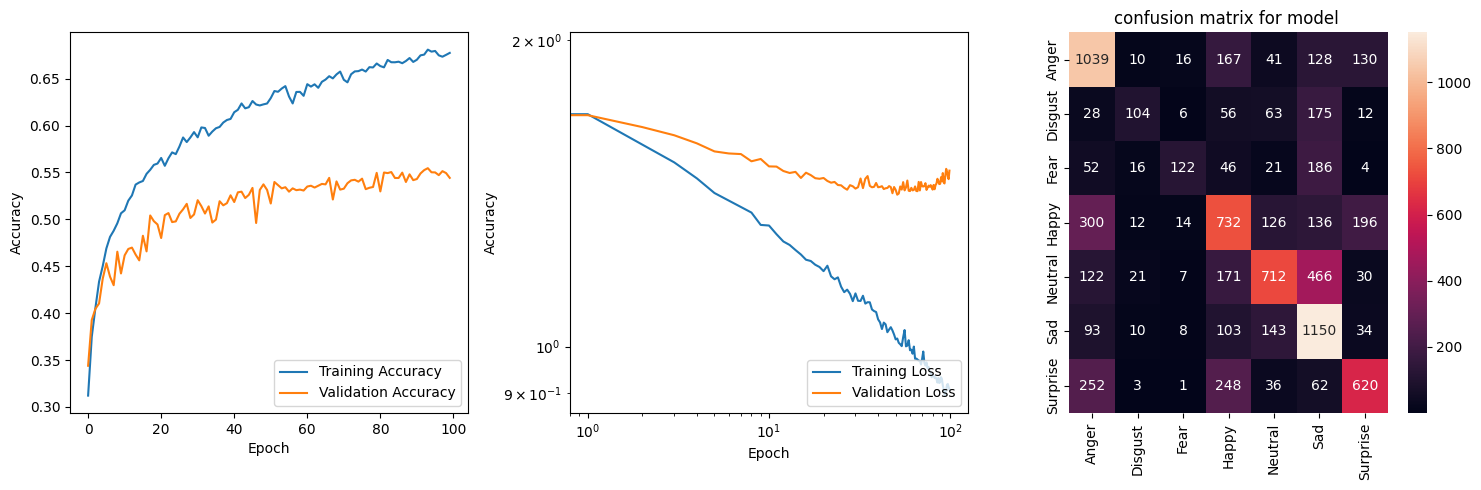

Model Confusion Matrix
               precision    recall  f1-score   support

       Anger       0.55      0.68      0.61      1531
     Disgust       0.59      0.23      0.34       444
        Fear       0.70      0.27      0.39       447
       Happy       0.48      0.48      0.48      1516
     Neutral       0.62      0.47      0.53      1529
         Sad       0.50      0.75      0.60      1541
    Surprise       0.60      0.51      0.55      1222

    accuracy                           0.54      8230
   macro avg       0.58      0.48      0.50      8230
weighted avg       0.56      0.54      0.53      8230



In [12]:
def plot_results(model, history, X_test, Y_test, Y_names):
    y_pred  = model.predict(X_test)
    y_pred  = np.argmax(y_pred, axis=1)
    y_check = np.argmax(Y_test,axis=1)
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

    conf = confusion_matrix(y_check, y_pred)
    cm = pd.DataFrame(
        conf, index=[i for i in Y_names],
        columns=[i for i in Y_names]
    )

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 1 row and 2 columns

    # Plot on first axis
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    # Plot on second axis
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.loglog()
    ax2.legend(loc='lower right')

    ax3 = sns.heatmap(cm,annot=True,fmt='d')
    ax3.set_title(f'confusion matrix for model ')

    # Optional: Adjust spacing between plots (optional)
    plt.tight_layout()

    plt.show()

    print(f'Model Confusion Matrix\n', classification_report(y_check, y_pred, target_names=Y_names))
plot_results(Normalized_CNN_1, Normalized_CNN_history_1, X_test, Y_test, Y_names)

In [13]:
pred_nn_train = Normalized_CNN_1.predict(X_train)
pred_nn_test = Normalized_CNN_1.predict(X_test)

601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# Two features

In [14]:
from enum import Enum
from sklearn.svm import SVC
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV

class EmotionMap(Enum):
    """
        Mapping of emotions into two components, valence and arousal.
        Based on an approximation from https://www.researchgate.net/figure/Emotion-Mapping-in-Valence-Arousal-Domains_fig2_348990229
    """
    Anger = (-0.75, 0.25)
    Disgust = (-0.25, -0.5)
    Fear = (-0.25, 0.75)
    Happy = (1, 0.25)
    Neutral = (0, 0)
    Sad = (-1, -0.5)
    Surprise = (0.75, 0.5)

    def map(labels, component: int, *, discrete: bool = False):
        continuous = np.array([getattr(EmotionMap, x).value[component] for x in labels])
        if not discrete:
            return continuous
        return np.array(continuous*4+4, dtype=np.int32)
    
    def map_both(labels, *, discrete: bool = False):
        return np.stack((
            EmotionMap.map(labels, 0, discrete=discrete),
            EmotionMap.map(labels, 1, discrete=discrete),
        ), axis=1)

    def reverse_map(valence, arousal, *, discrete: bool):
        point = np.array([valence, arousal])
        if discrete:
            point = (point-4)/4
        enum_values = np.array([emotion.value for emotion in EmotionMap])
        distances = np.linalg.norm(enum_values - point, axis=1)
        min_index = np.argmin(distances)
        closest_emotion = np.array([emotion.name for emotion in EmotionMap])[min_index]
    
        return closest_emotion
    
    
    def distances(valence, arousal, *, discrete: bool):
        point = np.array([valence, arousal])
        if discrete:
            point = (point-4)/4
        enum_values = np.array([emotion.value for emotion in EmotionMap])
        distances = np.linalg.norm(enum_values - point, axis=1)
        return distances

class TwoModelWrapper:
    def __init__(self, valenceModel, arousalModel):
        self.valenceModel = valenceModel
        self.arousalModel = arousalModel
        self._discrete = False

    def discrete(self):
        self._discrete = True
        return self

    def fit(self, X_train, y_train):
        self.valenceModel.fit(X_train, EmotionMap.map(y_train, 0, discrete=self._discrete))
        self.arousalModel.fit(X_train, EmotionMap.map(y_train, 1, discrete=self._discrete))
        return self
    
    def predict(self, X_test):
        valence = self.valenceModel.predict(X_test)
        arousal = self.arousalModel.predict(X_test)
        return np.array([EmotionMap.reverse_map(valence[i], arousal[i], discrete=self._discrete) for i in range(len(valence))])
    
    def predict_proba(self, X_test):
        valence = self.valenceModel.predict(X_test)
        arousal = self.arousalModel.predict(X_test)
        return np.array([EmotionMap.distances(valence[i], arousal[i], discrete=self._discrete) for i in range(len(valence))])

    @property
    def best_params_(self):
        return [self.valenceModel.best_params_, self.arousalModel.best_params_]


class SklearnTwoModelWrapper(TwoModelWrapper):
    def __init__(self, baseModel):
        super().__init__(clone(baseModel), clone(baseModel))

class KerasWrapper:
    def __init__(self, model):
        self.model = model

    def compile(self, *args, **kwargs):
        return self.model.compile(*args, **kwargs)

    def predict(self, *args, **kwargs):
        return self.model.predict(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        return self.model.evaluate(*args, **kwargs)
    
    def fit(self, X_train, Y_train, *args, validation_data, **kwargs):
        validation_data = (validation_data[0], EmotionMap.map_both(validation_data[1]))
        return self.model.fit(X_train, EmotionMap.map_both(Y_train), *args, validation_data=validation_data, **kwargs)

In [15]:
X = functional_features
Y = X['Emotion']
Y.unique()

array(['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'],
      dtype=object)

In [16]:
X = X.drop(['Emotion','filepath'], axis=1)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42) 

In [17]:

svm = SVC(random_state=42, C=100, gamma='auto', kernel='rbf')
svm = SklearnTwoModelWrapper(svm).discrete()

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7554070473876063


In [18]:
pred_svm_test = svm.predict_proba(X_test)
pred_svm_train = svm.predict_proba(X_train)
pred_svm_test = pred_svm_test/np.sum(pred_svm_test)
pred_svm_train = pred_svm_train/np.sum(pred_svm_train)

In [19]:
X_train_final = np.concatenate([pred_svm_train, pred_nn_train, pred_xgb_train], axis=1)
X_test_final = np.concatenate([pred_svm_test, pred_nn_test, pred_xgb_test], axis=1)

In [20]:
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [21]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 4, 6,8],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}
grid = RandomizedSearchCV(xgb_model, param_grid, refit=True, verbose=1,cv=3,n_iter=15,random_state=42)
grid.fit(X_train_final, y_train)

print(grid.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
{'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05}


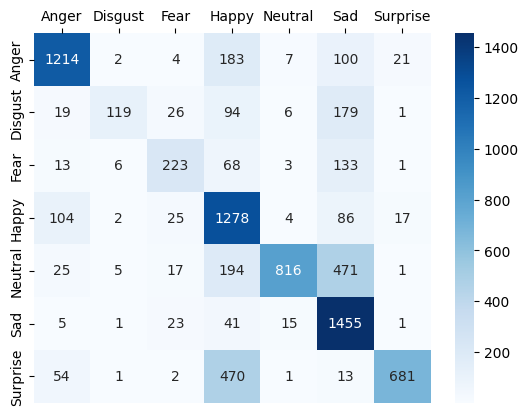

Accuracy: 0.7030376670716889


In [22]:
y_pred = grid.predict(X_test_final)

y_true_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)
df_cm = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
axs = sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
axs.xaxis.set_ticks_position('top')
plt.show()
print("Accuracy:", accuracy_score(y_test, y_pred))

In [23]:
svm_model= SVC(random_state=42)
param_grid = {'C': [0.1, 1, 10,100], 'gamma': [1, 0.1, 0.01, 0.001,'auto'], 'kernel': ['linear', 'rbf']}
grid = RandomizedSearchCV(svm_model, param_grid, refit=True,verbose=1,cv=3,n_iter=10,random_state=42)
grid.fit(X_train_final, y_train)

print(grid.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'kernel': 'rbf', 'gamma': 'auto', 'C': 1}


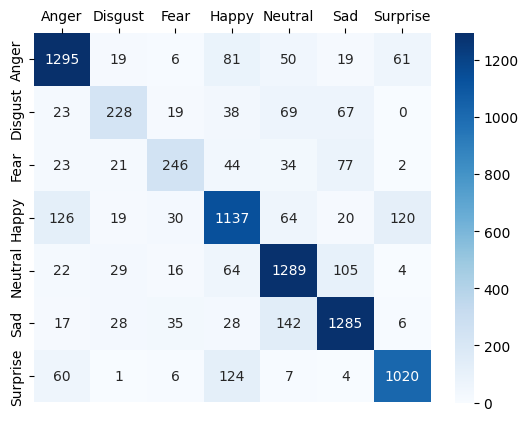

Accuracy: 0.7897934386391251


In [24]:
y_pred = grid.predict(X_test_final)

y_true_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)
df_cm = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
axs = sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
axs.xaxis.set_ticks_position('top')
plt.show()
print("Accuracy:", accuracy_score(y_test, y_pred))

In [25]:
pd.DataFrame(grid.best_estimator_.dual_coef_)

,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,314
0,0.000000,1.0,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.0,...,-0.0,-0.0,-0.000000,-0.000000,-1.0,-0.0,-0.0,-0.878458,-0.0,-0.000000
1,0.000000,1.0,0.0,0.000000,0.0,0.0,0.577629,0.000000,0.0,0.0,...,-0.0,-0.0,-0.469987,-0.000000,-0.0,-0.0,-1.0,-1.000000,-0.0,-0.000000
2,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.0,...,-1.0,-0.0,-0.000000,-0.464016,-0.0,-0.0,-0.0,-0.269865,-1.0,-0.000000
3,0.353298,1.0,1.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,0.0,...,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.0,-0.0,-1.000000,-0.0,-0.041213
4,0.000000,1.0,0.0,0.000000,0.0,1.0,0.000000,0.063043,0.0,0.0,...,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.0,-0.0,-1.000000,-0.0,-0.000000
5,0.000000,1.0,0.0,0.456525,0.0,0.0,0.000000,0.000000,1.0,0.0,...,-0.0,-1.0,-0.000000,-0.000000,-0.0,-1.0,-0.0,-1.000000,-0.0,-0.000000
